In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

from functools import reduce

# Relative Deprivation and Economic Preference

Household debt among young people in Korea has soared since the COVID-19 pandemic last year. '빚투', which is the term for 'invest out of debt', is one of the reasons for the surge. The greater the social inequality, the more important the social status, and the motivation to improve one's disadvantage is put first. With asset polarization accelerating, young people prefer alternatives that can close social gaps in a short period of time, although the risk of loss is high.

This notebook considers the rapidly increasing household debt and risk assets to be caused by inequality, and aims to intensively analyze the impact of social inequality on economic behavior.

**Question**:

        Q1 : How does relative deprivation affect individual risk averse rate?
    
        Q2 : Does relative deprivation affect the proportion of risky assets?

# Data

The data for this analysis are from Korean Institute of Public Finance(KIPF), a nationally representative longitudinal study of households in Korea. The households were selected using two-staged stratified sampling. 

2017 to 2020 data were used and extracted households that have had the same household head for 4 consecutive years. After excluding observation with missing values, the final sample includes $4236(households) * 4(years)$ observations.

In [4]:
df13h = pd.read_csv('/Users/jinc/Desktop/프로젝트/학부연구/재정패널조사/[NaSTaB]EXCEL_H/NaSTaB13H.csv')
df12h = pd.read_csv('/Users/jinc/Desktop/프로젝트/학부연구/재정패널조사/[NaSTaB]EXCEL_H/NaSTaB12H.csv')
df11h = pd.read_csv('/Users/jinc/Desktop/프로젝트/학부연구/재정패널조사/[NaSTaB]EXCEL_H/NaSTaB11H.csv')
df10h = pd.read_csv('/Users/jinc/Desktop/프로젝트/학부연구/재정패널조사/[NaSTaB]EXCEL_H/NaSTaB10H.csv')

In [5]:
df13p = pd.read_csv('/Users/jinc/Desktop/프로젝트/학부연구/재정패널조사/[NaSTaB]EXCEL_P/NaSTaB13P.csv')
df12p = pd.read_csv('/Users/jinc/Desktop/프로젝트/학부연구/재정패널조사/[NaSTaB]EXCEL_P/NaSTaB12P.csv')
df11p = pd.read_csv('/Users/jinc/Desktop/프로젝트/학부연구/재정패널조사/[NaSTaB]EXCEL_P/NaSTaB11P.csv')
df10p = pd.read_csv('/Users/jinc/Desktop/프로젝트/학부연구/재정패널조사/[NaSTaB]EXCEL_P/NaSTaB10P.csv')

In [6]:
# Household data
df13h = df13h.rename(columns={'hid13':'hid'})
df12h = df12h.rename(columns={'hid12':'hid'})
df11h = df11h.rename(columns={'hid11':'hid'})
df10h = df10h.rename(columns={'hid10':'hid'})

# Personal data
df13p = df13p.rename(columns={'pid13':'pid', 'hid13':'hid'})
df12p = df12p.rename(columns={'pid12':'pid', 'hid12':'hid'})
df11p = df11p.rename(columns={'pid11':'pid', 'hid11':'hid'})
df10p = df10p.rename(columns={'pid10':'pid', 'hid10':'hid'})

In [7]:
def demographic(data, yr):

    df = data.replace(-9, np.NaN)
    demo = {'hid':[],
            'pid':[],
            'yid':[],
            'age': [],
            'gender':[],
            'martial':[],
            'education':[],
            'employment':[],
            'income':[]}


    var = [f'w{yr}rel0{i}' if len(str(i))==1 else f'w{yr}rel{i}' for i in range(1,11)]
    for n in range(df.shape[0]):
        for m,j in enumerate(var):

            if len(str(m+1)) == 1:
                m = f'0{m+1}'
            else:
                m = m+1

            if df.loc[n,j] == 1:
                # HID
                demo['hid'].append(df.loc[n,'hid'])
                # extract PID
                demo['pid'].append(int((df.loc[n,'hid']*100) + int(j[-2:])))
                #year
                demo['yid'] = yr
                # age = survey year - birthyear
                age = (2007+yr) - (df.loc[n,f'w{yr}byr{m}'])
                demo['age'].append(age)
                # gender: female =1 / if not = 0
                if df.loc[n,f'w{yr}gen{m}'] == 2:
                    demo['gender'].append(1)
                else:
                    demo['gender'].append(0)
                # martial status: partner = 1 / if not = 0
                if df.loc[n,f'w{yr}mar{m}'] == 1:
                    demo['martial'].append(1)
                else:
                    demo['martial'].append(0)
                # education status: highschool grad or below = 0, college grad and above =1
                if df.loc[n,f'w{yr}edu{m}'] == np.NaN:
                    demo['education'].append(np.NaN)
                elif df.loc[n,f'w{yr}edu{m}'] >= 5:
                    demo['education'].append(1)
                # elif df.loc[n,f'w{yr}edu{m}'] == 4:
                #     demo['education'].append(0)
                else:
                    demo['education'].append(0)
                # employment status: unemployed = 1, wage-employed = 2, self-employed = 3
                if df.loc[n,f'w{yr}job{m}'] > 11:
                    demo['employment'].append(1)
                elif df.loc[n,f'w{yr}jpo{m}'] < 4:
                    demo['employment'].append(2)
                elif df.loc[n,f'w{yr}jpo{m}'] >= 4:
                    demo['employment'].append(3)
                else:
                    demo['employment'].append(np.NaN)
                # region - data only in 13
                # try:
                #     demo['region'].append(df.loc[n,f'w{yr}pbb{m}'])
                # except:
                #     demo['region'].append(np.NaN)
                # income = equivalent 
                hhincome = df.loc[n,f'h{yr}ca004']
                members = df.loc[n,f'h{yr}aa007']
                demo['income'].append(hhincome / np.sqrt(members))
                

    return pd.DataFrame(demo)        

In [8]:
demo10 = demographic(df10h, 10)
demo11 = demographic(df11h, 11)
demo12 = demographic(df12h, 12)
demo13 = demographic(df13h, 13)

In [9]:
def netAsset(data, yr):
    df = data.replace(-9, np.NaN)
    
    info = {'hid':[],
            'yid':[],
            'netAsset':[]}
    for n in range(df.shape[0]):

        info['hid'].append(df.loc[n,'hid'])
        info['yid'].append(yr)
        # net asset = asset - liabilities
        # Liabilities
        liabilities = [f'h{yr}fc003', 
                    f'h{yr}fc006',
                    f'h{yr}fc009',
                    f'h{yr}fc012',
                    f'h{yr}fc015',
                    f'h{yr}fc017',
                    f'h{yr}fc019']
        liabilitiesTotal = df.loc[n,liabilities].sum(skipna=True)
        # Asset
        financialAsset = [f'h{yr}fa002',
                        f'h{yr}fa004',
                        f'h{yr}fa006',
                        f'h{yr}fa008',
                        f'h{yr}fa010',
                        f'h{yr}fa012',
                        f'h{yr}fa014',
                        f'h{yr}fa016',
                        f'h{yr}fa018']
        nonfinancialAsset = [f'h{yr}fb002',
                            f'h{yr}fb004',
                            f'h{yr}fb006',
                            f'h{yr}fb008',
                            f'h{yr}fb010',
                            f'h{yr}fb012',
                            f'h{yr}fb014',
                            f'h{yr}fb020',
                            f'h{yr}fb022',
                            f'h{yr}fb024',
                            f'h{yr}fb026',
                            f'h{yr}fb031',
                            f'h{yr}fb016',
                            f'h{yr}fb018',]
        assetTotal = df.loc[n,financialAsset+nonfinancialAsset].sum(skipna=True)
        info['netAsset'].append(assetTotal - liabilitiesTotal)

    return pd.DataFrame(info)


In [10]:
asset10 = netAsset(df10h, 10)
asset11 = netAsset(df11h, 11)
asset12 = netAsset(df12h, 12)
asset13 = netAsset(df13h, 13)

In [11]:
def risk(df, yr):
    risk = {'pid':[],
            'yid':[],
            'riskAverse':[]}
    for n in range(df.shape[0]):
        risk['pid'].append(df.loc[n,'pid'])
        risk['yid'].append(yr)
        risk['riskAverse'].append(df.loc[n,f'p{yr}gf001'])
    return pd.DataFrame(risk)

In [12]:
risk10 = risk(df10p,10)
risk11 = risk(df11p,11)
risk12 = risk(df12p,12)
risk13 = risk(df13p,13)

In [13]:
demo = pd.concat([demo10,demo11,demo12,demo13])
asset = pd.concat([asset10,asset11,asset12,asset13])
risk = pd.concat([risk10,risk11,risk12,risk13])

df = pd.merge(demo, asset, how='left', on=['hid','yid'])
df = pd.merge(df, risk, how='left', on=['pid','yid'])

In [14]:
# Extract households with same head for 4 years
a = df.groupby('pid').count().hid.to_frame()
pidFourYears = a[a.hid==4].index
df = df[df.pid.isin(pidFourYears)].sort_values(by=['hid','yid']).reset_index(drop=True)

df = df.drop(columns='pid')

## Relative Deprivation

Relative deprivation(RD) refers to the belief that one is worse off than others and does not have what they deserved. In previous studies, it is known that perceiving inequality provokes risky behaviors.

People are often motivated to get out of adverse state and engage in various behavior to get what they believe they deserve. However, if such effort fails, the desire for risky rewards increases because these rewards offers the chance of improving one's financial situation dramatically. 

### Reference Group

Individuals compare themselves with relative other, with similar characteristics. This notebook have defined reference group based on demographic and geographic traits. The reference groups were defined with combinations of **1)age, 2)gender, 3)martial status, 4)education, 5)employment status, 6)residence.**

In [15]:
group = df.copy()

# age group
for n in range(group.shape[0]):
    if (group.loc[n,'age'] >= 20) & (group.loc[n,'age'] < 40):
        group.loc[n,'ageGroup'] = 1
    elif (group.loc[n,'age'] >= 40) & (group.loc[n,'age'] < 50):
        group.loc[n,'ageGroup'] = 2
    elif (group.loc[n,'age'] >= 50) & (group.loc[n,'age'] < 60):
        group.loc[n,'ageGroup'] = 3
    else:
        group.loc[n,'ageGroup'] = 4

In [16]:
# region 
# region - data only in 13
region = {'hid':[],
          'region':[]}
var = [f'w13rel0{i}' if len(str(i))==1 else f'w13rel{i}' for i in range(1,11)]
for n in range(df13h.shape[0]):
        for m,j in enumerate(var):
                if len(str(m+1)) == 1:
                        m = f'0{m+1}'
                else:
                        m = m+1
                if df13h.loc[n,j] == 1:
                        region['hid'].append(df13h.loc[n,'hid'])
                        region['region'].append(df13h.loc[n,f'w13pbb{m}'])

region = pd.DataFrame(region)
group = group.merge(region, how='left', on='hid')

In [17]:
# region group
# 1)Seoul 2)Metropolitan city 3)City 4)Rural area
for n in range(group.shape[0]):
    if (group.loc[n,'region'] > 10000) & (group.loc[n,'region'] < 20000):
        group.loc[n,'regionGroup'] = 1
    elif (group.loc[n,'region'] > 20000) & (group.loc[n,'region'] < 30000):
        group.loc[n,'regionGroup'] = 2
    elif (group.loc[n,'region'] > 31000) & (group.loc[n,'region'] < 31330):
        group.loc[n,'regionGroup'] = 3
    elif (group.loc[n,'region'] > 32000) & (group.loc[n,'region'] < 32300):
        group.loc[n,'regionGroup'] = 3
    elif (group.loc[n,'region'] > 33000) & (group.loc[n,'region'] < 33300):
        group.loc[n,'regionGroup'] = 3
    elif (group.loc[n,'region'] > 34000) & (group.loc[n,'region'] < 34300):
        group.loc[n,'regionGroup'] = 3
    elif (group.loc[n,'region'] > 35000) & (group.loc[n,'region'] < 35300):
        group.loc[n,'regionGroup'] = 3
    elif (group.loc[n,'region'] > 36000) & (group.loc[n,'region'] < 36300):
        group.loc[n,'regionGroup'] = 3
    elif (group.loc[n,'region'] > 37000) & (group.loc[n,'region'] < 37300):
        group.loc[n,'regionGroup'] = 3
    elif (group.loc[n,'region'] > 38000) & (group.loc[n,'region'] < 38300):
        group.loc[n,'regionGroup'] = 3
    else:
        group.loc[n,'regionGroup'] = 4


In [18]:
#reference group id
# gender=2 edu=2 age=4 region=4
df['gid'] = ((group['gender']+1) * 1000) + ((group['education']+1) * 100) + (group['ageGroup'] * 10) + group['regionGroup']

In [19]:
df.replace(1114,1113, inplace=True)
df.replace(2111,2112, inplace=True)
df.replace(2113,2114, inplace=True)
df.replace(2241,1241, inplace=True)
df.replace(2242,1242, inplace=True)
df.replace(2231,2232, inplace=True)
df.replace(2121,2122, inplace=True)
df.replace(2244,2243, inplace=True)

The reference group with observation less than 30, were merged into the nearest group to get enough sample size of each group. As a result, observations were categorized into 56 different groups with the size of about 302 observation.

### RD measurement

**Yitzhaki Index**

$Yitzhaki_i = \frac{1}{N} \Sigma(y_j - y_i)I_{ij}$ 
$$I_{ij}\begin{cases}
1, & y_j > y_i \\
0, & y_j \le y_i
\end{cases}$$

The first measurement is proposed by Yitzhaki, where N is the total number of individuals in each reference group. RD will increase for the sum of all income differences between individual $i$ and for all $j$ with income greater than individual $i$.

In [20]:
gid = df.gid.unique()
# Yitzhaki Index
result = []
# for each group
for n in gid:
    # for each year
    for y in range(10,14):
        group = df[(df.gid == n) & (df.yid == y)].reset_index(drop=True)
        N = group.shape[0]
        # for each individual i
        for i in range(N):
            diff = 0
            # individuals j
            for j in range(N):
                # get difference only if j is greater than i
                if (group.loc[i,'income'] < group.loc[j,'income']):
                    diff += (group.loc[j,'income'] - group.loc[i,'income'])       
            result.append([group.loc[i,'hid'], y, (diff/N)])
                
                
yitzhaki = pd.DataFrame(result, columns=['hid','yid','Yitzhaki'])

**Deaton Index**

$Deaton_i = \frac{1}{N\mu} \Sigma(y_j - y_i)I_{ij}$ 
$$I_{ij}\begin{cases}
1, & y_j > y_i \\
0, & y_j \le y_i
\end{cases}$$

Deaton index is same as Yitzhaki index but scaled by the mean income of the reference group. This makes the index consider the total income differences between the groups and values range from 0 to 1.

In [21]:
gid = df.gid.unique()
# Deaton Index
result = []
# for each group
for n in gid:
    # for each year
    for y in range(10,14):
        group = df[(df.gid == n) & (df.yid == y)].reset_index(drop=True)
        N = group.shape[0]
        # for each individual i
        for i in range(N):
            diff = 0
            # individuals j
            for j in range(N):
                # get difference only if j is greater than i
                if (group.loc[i,'income'] < group.loc[j,'income']):
                    diff += (group.loc[j,'income'] - group.loc[i,'income'])
            meanIncome = group.income.mean()    
            result.append([group.loc[i,'hid'], y, (diff/(N*meanIncome))])
                
                
deaton = pd.DataFrame(result, columns=['hid','yid','Deaton'])

In [22]:
df = df.merge(yitzhaki, how='left', on=['hid','yid'])
df = df.merge(deaton, how='left', on=['hid','yid'])

**Characteristics**
<style>
table,td,tr,th {border:none!important}
</style>

<table style="font-size: 10px; margin-left: auto; margin-right: auto; text-align: left;">
    <tr">
        <th>  </th><th style="width:20%">N</th><th style="width:20%">Mean</th><th style="width:20%">SD</th>
    </tr>
    <tr>
        <td style="font-size: 12px;"><b>Age</b></td>
        <td>16,944</td>
        <td>57.56</td>
        <td>14.37</td>
    </tr>
    <tr>
        <td style="font-size: 12px;"><b>Gender</b></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td style="font-size: 12px;">&nbsp;&nbsp;&nbsp;Male</td>
        <td>13252</td>
        <td>78.21%</td>
        <td></td>
    </tr>
    <tr>
        <td style="font-size: 12px;">&nbsp;&nbsp;&nbsp;Female</td>
        <td>3692</td>
        <td>21.79%</td>
        <td></td>
    </tr>
    <tr>
        <td style="font-size: 12px;"><b>Martial status</b></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td style="font-size: 12px;">&nbsp;&nbsp;&nbsp;Married</td>
        <td>12441</td>
        <td>73.42%</td>
        <td></td>
    </tr>
    <tr>
        <td style="font-size: 12px;">&nbsp;&nbsp;&nbsp;&nbsp;Alone</td>
        <td>4503</td>
        <td>26.58%</td>
        <td></td>
    </tr>
    <tr>
        <td style="font-size: 12px;"><b>Education</b></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td style="font-size: 12px;">&nbsp;&nbsp;&nbsp;&nbsp;Highschool or less</td>
        <td>9509</td>
        <td>56.12%</td>
        <td></td>
    </tr>
    <tr>
        <td style="font-size: 12px;">&nbsp;&nbsp;&nbsp;&nbsp;College or higher</td>
        <td>7435</td>
        <td>43.88</td>
        <td></td>
    </tr>
    <tr>
        <td style="font-size: 12px;"><b>Employment</b></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td style="font-size: 12px;">&nbsp;&nbsp;&nbsp;&nbsp;Wage-employed</td>
        <td>8861</td>
        <td>52.30</td>
        <td></td>
    </tr>
    <tr>
        <td style="font-size: 12px;">&nbsp;&nbsp;&nbsp;&nbsp;Self-employed</td>
        <td>4396</td>
        <td>25.95%</td>
        <td></td>
    </tr>
    <tr>
        <td style="font-size: 12px;">&nbsp;&nbsp;&nbsp;&nbsp;Unemployed</td>
        <td>3685</td>
        <td>21.75</td>
        <td></td>
    </tr>
    <tr>
        <td style="font-size: 12px;"><b>Houshold income</b></td>
        <td>16,944</td>
        <td>248.04</td>
        <td>189.61</td>
    </tr>
    <tr>
        <td style="font-size: 12px;"><b>Net asset</b></td>
        <td>16,944</td>
        <td>4,1461</td>
        <td>7.9146</td>
    </tr>
    <tr>
        <td style="font-size: 12px;"><b>Risk averse</b></td>
        <td>16,944</td>
        <td>8.22</td>
        <td>3.02</td>
    </tr>
    

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

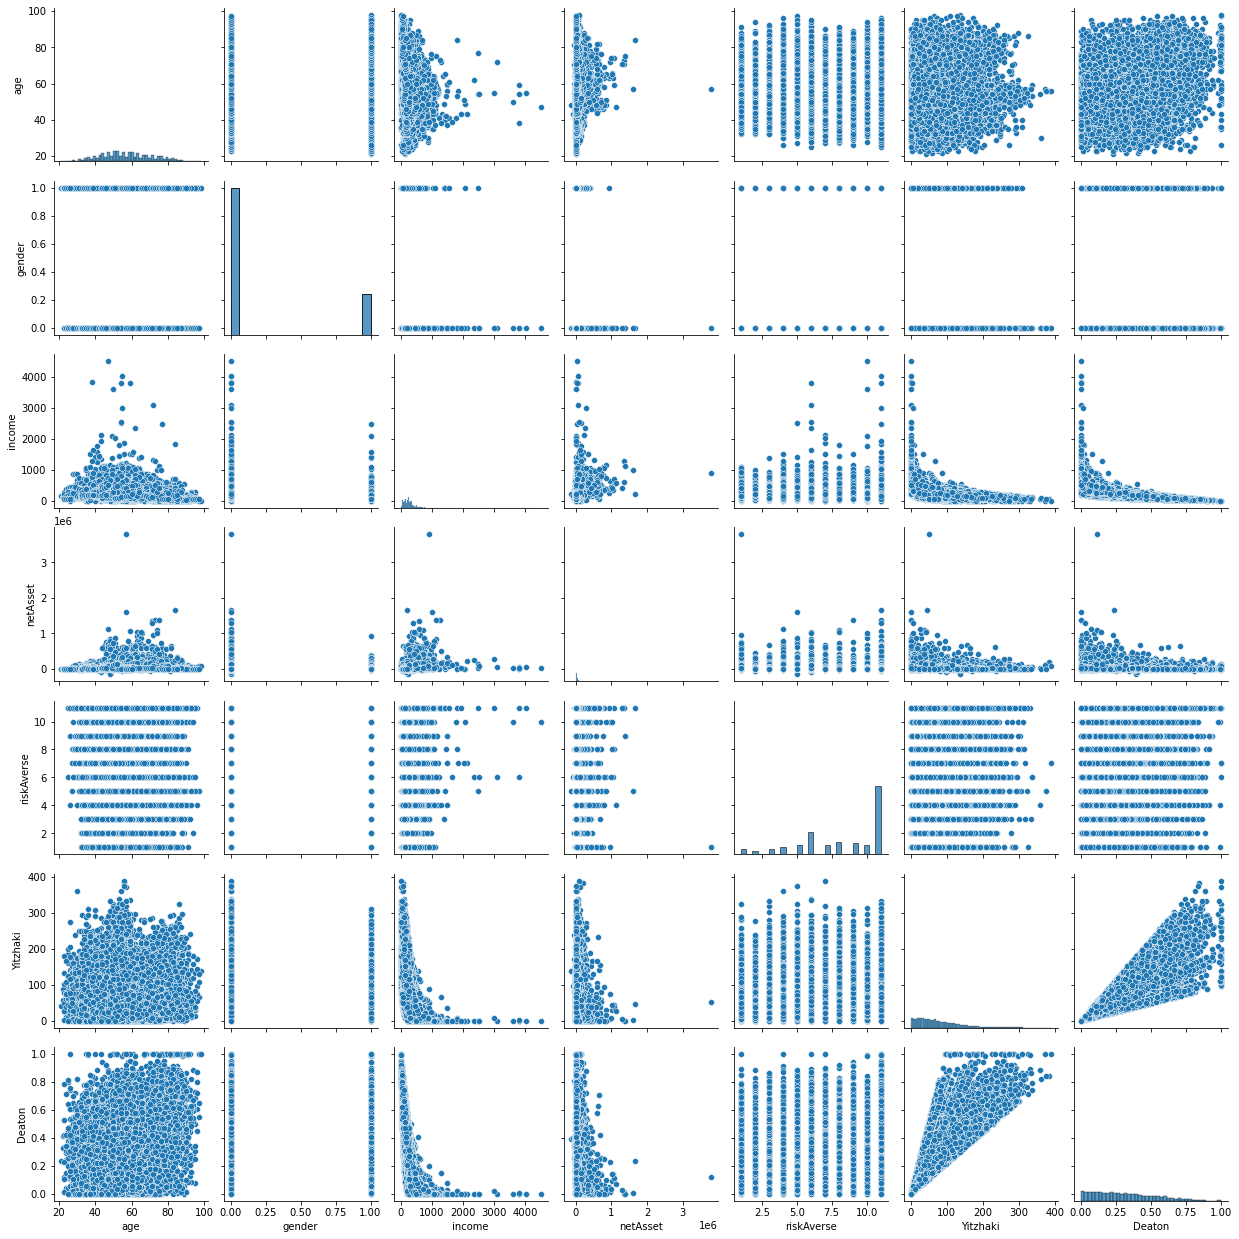

In [37]:
a = df[['age','gender','income','netAsset','riskAverse','Yitzhaki','Deaton']]
sns.pairplot(a)

<AxesSubplot:xlabel='income', ylabel='Density'>

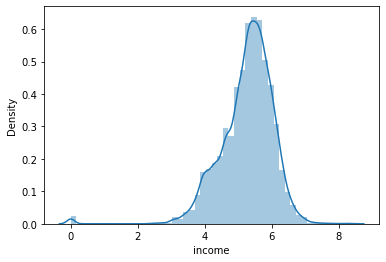

In [40]:
sns.distplot(np.log(df.income+1))

<AxesSubplot:xlabel='netAsset', ylabel='Density'>

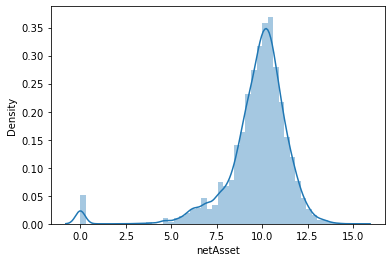

In [43]:
sns.distplot(df.netAsset)
sns.distplot(np.log(df.netAsset+1))

In [ ]:
impor